# Erstellen Sie ein Klassifikationsmodell: Köstliche asiatische und indische Küchen


## Küchenklassifikatoren 1

In dieser Lektion werden wir eine Vielzahl von Klassifikatoren erkunden, um *eine nationale Küche basierend auf einer Gruppe von Zutaten vorherzusagen.* Dabei lernen wir mehr über einige der Möglichkeiten, wie Algorithmen für Klassifikationsaufgaben eingesetzt werden können.

### [**Quiz vor der Vorlesung**](https://gray-sand-07a10f403.1.azurestaticapps.net/quiz/21/)

### **Vorbereitung**

Diese Lektion baut auf unserer [vorherigen Lektion](https://github.com/microsoft/ML-For-Beginners/blob/main/4-Classification/1-Introduction/solution/lesson_10-R.ipynb) auf, in der wir:

-   Eine sanfte Einführung in Klassifikationen anhand eines Datensatzes über die großartigen Küchen Asiens und Indiens 😋 gemacht haben.

-   Einige [dplyr-Verben](https://dplyr.tidyverse.org/) erkundet haben, um unsere Daten vorzubereiten und zu bereinigen.

-   Wunderschöne Visualisierungen mit ggplot2 erstellt haben.

-   Demonstriert haben, wie man mit unausgewogenen Daten umgeht, indem man sie mit [recipes](https://recipes.tidymodels.org/articles/Simple_Example.html) vorverarbeitet.

-   Gezeigt haben, wie man unser Rezept `prep` und `bake`, um sicherzustellen, dass es wie vorgesehen funktioniert.

#### **Voraussetzungen**

Für diese Lektion benötigen wir die folgenden Pakete, um unsere Daten zu bereinigen, vorzubereiten und zu visualisieren:

-   `tidyverse`: Das [tidyverse](https://www.tidyverse.org/) ist eine [Sammlung von R-Paketen](https://www.tidyverse.org/packages), die darauf abzielt, Datenwissenschaft schneller, einfacher und unterhaltsamer zu machen!

-   `tidymodels`: Das [tidymodels](https://www.tidymodels.org/) Framework ist eine [Sammlung von Paketen](https://www.tidymodels.org/packages/) für Modellierung und maschinelles Lernen.

-   `themis`: Das [themis-Paket](https://themis.tidymodels.org/) bietet zusätzliche Rezeptschritte für den Umgang mit unausgewogenen Daten.

-   `nnet`: Das [nnet-Paket](https://cran.r-project.org/web/packages/nnet/nnet.pdf) bietet Funktionen zur Schätzung von Feedforward-Neuronalen Netzen mit einer einzigen versteckten Schicht sowie für multinomiale logistische Regressionsmodelle.

Sie können diese Pakete wie folgt installieren:


`install.packages(c("tidyverse", "tidymodels", "DataExplorer", "here"))`

Alternativ überprüft das folgende Skript, ob die für dieses Modul benötigten Pakete vorhanden sind, und installiert sie für Sie, falls sie fehlen.


In [2]:
suppressWarnings(if (!require("pacman"))install.packages("pacman"))

pacman::p_load(tidyverse, tidymodels, themis, here)

Loading required package: pacman



Jetzt legen wir los!

## 1. Teile die Daten in Trainings- und Testdatensätze auf.

Wir beginnen mit ein paar Schritten aus unserer vorherigen Lektion.

### Entferne die häufigsten Zutaten, die Verwirrung zwischen verschiedenen Küchenstilen stiften, mit `dplyr::select()`.

Jeder liebt Reis, Knoblauch und Ingwer!


In [3]:
# Load the original cuisines data
df <- read_csv(file = "https://raw.githubusercontent.com/microsoft/ML-For-Beginners/main/4-Classification/data/cuisines.csv")

# Drop id column, rice, garlic and ginger from our original data set
df_select <- df %>% 
  select(-c(1, rice, garlic, ginger)) %>%
  # Encode cuisine column as categorical
  mutate(cuisine = factor(cuisine))

# Display new data set
df_select %>% 
  slice_head(n = 5)

# Display distribution of cuisines
df_select %>% 
  count(cuisine) %>% 
  arrange(desc(n))

New names:
* `` -> ...1

Rows: 2448 Columns: 385

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (1): cuisine
dbl (384): ...1, almond, angelica, anise, anise_seed, apple, apple_brandy, a...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



cuisine almond angelica anise anise_seed apple apple_brandy apricot armagnac
1 indian  0      0        0     0          0     0            0       0       
2 indian  1      0        0     0          0     0            0       0       
3 indian  0      0        0     0          0     0            0       0       
4 indian  0      0        0     0          0     0            0       0       
5 indian  0      0        0     0          0     0            0       0       
  artemisia ⋯ whiskey white_bread white_wine whole_grain_wheat_flour wine wood
1 0         ⋯ 0       0           0          0                       0    0   
2 0         ⋯ 0       0           0          0                       0    0   
3 0         ⋯ 0       0           0          0                       0    0   
4 0         ⋯ 0       0           0          0                       0    0   
5 0         ⋯ 0       0           0          0                       0    0   
  yam yeast yogurt zucchini
1 0   0     0      0       
2 0   0     0      0       
3 0   0     0      0       
4 0   0     0      0       
5 0   0     1      0

cuisine  n  
1 korean   799
2 indian   598
3 chinese  442
4 japanese 320
5 thai     289

Perfekt! Jetzt teilen wir die Daten so auf, dass 70 % der Daten für das Training und 30 % für das Testen verwendet werden. Dabei wenden wir eine `Stratifizierung` an, um `das Verhältnis der einzelnen Küchenarten` in den Trainings- und Validierungsdatensätzen beizubehalten.

[rsample](https://rsample.tidymodels.org/), ein Paket in Tidymodels, bietet eine Infrastruktur für effizientes Aufteilen und Resampling von Daten:


In [4]:
# Load the core Tidymodels packages into R session
library(tidymodels)

# Create split specification
set.seed(2056)
cuisines_split <- initial_split(data = df_select,
                                strata = cuisine,
                                prop = 0.7)

# Extract the data in each split
cuisines_train <- training(cuisines_split)
cuisines_test <- testing(cuisines_split)

# Print the number of cases in each split
cat("Training cases: ", nrow(cuisines_train), "\n",
    "Test cases: ", nrow(cuisines_test), sep = "")

# Display the first few rows of the training set
cuisines_train %>% 
  slice_head(n = 5)


# Display distribution of cuisines in the training set
cuisines_train %>% 
  count(cuisine) %>% 
  arrange(desc(n))

Training cases: 1712
Test cases: 736

cuisine almond angelica anise anise_seed apple apple_brandy apricot armagnac
1 chinese 0      0        0     0          0     0            0       0       
2 chinese 0      0        0     0          0     0            0       0       
3 chinese 0      0        0     0          0     0            0       0       
4 chinese 0      0        0     0          0     0            0       0       
5 chinese 0      0        0     0          0     0            0       0       
  artemisia ⋯ whiskey white_bread white_wine whole_grain_wheat_flour wine wood
1 0         ⋯ 0       0           0          0                       1    0   
2 0         ⋯ 0       0           0          0                       1    0   
3 0         ⋯ 0       0           0          0                       0    0   
4 0         ⋯ 0       0           0          0                       0    0   
5 0         ⋯ 0       0           0          0                       0    0   
  yam yeast yogurt zucchini
1 0   0     0      0       
2 0   0     0      0       
3 0   0     0      0       
4 0   0     0      0       
5 0   0     0      0

cuisine  n  
1 korean   559
2 indian   418
3 chinese  309
4 japanese 224
5 thai     202

## 2. Umgang mit unausgewogenen Daten

Wie Sie vielleicht im ursprünglichen Datensatz sowie in unserem Trainingssatz bemerkt haben, gibt es eine ziemlich ungleiche Verteilung der Anzahl der Küchen. Koreanische Küchen sind *fast* dreimal so häufig wie thailändische Küchen. Unaussgewogene Daten haben oft negative Auswirkungen auf die Modellleistung. Viele Modelle funktionieren am besten, wenn die Anzahl der Beobachtungen gleich ist, und haben daher Schwierigkeiten mit unausgewogenen Daten.

Es gibt hauptsächlich zwei Möglichkeiten, mit unausgewogenen Datensätzen umzugehen:

-   Hinzufügen von Beobachtungen zur Minderheitsklasse: `Over-Sampling`, z. B. mit einem SMOTE-Algorithmus, der synthetisch neue Beispiele der Minderheitsklasse anhand der nächsten Nachbarn dieser Fälle generiert.

-   Entfernen von Beobachtungen aus der Mehrheitsklasse: `Under-Sampling`

In unserer vorherigen Lektion haben wir demonstriert, wie man mit unausgewogenen Datensätzen mithilfe eines `recipe` umgehen kann. Ein Rezept kann als eine Art Blaupause betrachtet werden, die beschreibt, welche Schritte auf einen Datensatz angewendet werden sollten, um ihn für die Datenanalyse vorzubereiten. In unserem Fall möchten wir eine gleichmäßige Verteilung der Anzahl unserer Küchen für unseren `training set` erreichen. Lassen Sie uns direkt loslegen.


In [5]:
# Load themis package for dealing with imbalanced data
library(themis)

# Create a recipe for preprocessing training data
cuisines_recipe <- recipe(cuisine ~ ., data = cuisines_train) %>% 
  step_smote(cuisine)

# Print recipe
cuisines_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor        380

Operations:

SMOTE based on cuisine

Du kannst natürlich bestätigen (mithilfe von prep+bake), dass das Rezept wie erwartet funktioniert – alle Küchenlabels haben `559` Beobachtungen.

Da wir dieses Rezept als Vorverarbeitung für das Modellieren verwenden werden, übernimmt ein `workflow()` den gesamten Vorbereitungs- und Backprozess für uns, sodass wir das Rezept nicht manuell schätzen müssen.

Jetzt sind wir bereit, ein Modell zu trainieren 👩‍💻👨‍💻!

## 3. Auswahl des Klassifikators

<p >
   <img src="../../images/parsnip.jpg"
   width="600"/>
   <figcaption>Kunstwerk von @allison_horst</figcaption>


Jetzt müssen wir entscheiden, welchen Algorithmus wir für die Aufgabe verwenden 🤔.

In Tidymodels bietet das [`parsnip package`](https://parsnip.tidymodels.org/index.html) eine einheitliche Schnittstelle für die Arbeit mit Modellen über verschiedene Engines (Pakete) hinweg. Bitte sehen Sie sich die parsnip-Dokumentation an, um [Modelltypen und Engines](https://www.tidymodels.org/find/parsnip/#models) sowie deren entsprechende [Modellargumente](https://www.tidymodels.org/find/parsnip/#model-args) zu erkunden. Die Vielfalt kann auf den ersten Blick ziemlich überwältigend sein. Zum Beispiel umfassen die folgenden Methoden alle Klassifikationstechniken:

-   C5.0 Regelbasierte Klassifikationsmodelle

-   Flexible Diskriminanzmodelle

-   Lineare Diskriminanzmodelle

-   Regularisierte Diskriminanzmodelle

-   Logistische Regressionsmodelle

-   Multinomiale Regressionsmodelle

-   Naive Bayes Modelle

-   Support Vector Machines

-   Nächste Nachbarn

-   Entscheidungsbäume

-   Ensemble-Methoden

-   Neuronale Netze

Die Liste geht weiter!

### **Welchen Klassifikator wählen?**

Welchen Klassifikator sollten Sie also wählen? Oft ist es eine gute Methode, mehrere auszuprobieren und nach einem guten Ergebnis zu suchen.

> AutoML löst dieses Problem elegant, indem es diese Vergleiche in der Cloud durchführt und Ihnen ermöglicht, den besten Algorithmus für Ihre Daten auszuwählen. Probieren Sie es [hier](https://docs.microsoft.com/learn/modules/automate-model-selection-with-azure-automl/?WT.mc_id=academic-77952-leestott) aus.

Die Wahl des Klassifikators hängt auch von unserem Problem ab. Wenn das Ergebnis beispielsweise in `mehr als zwei Klassen` kategorisiert werden kann, wie in unserem Fall, müssen Sie einen `Multiklassen-Klassifikationsalgorithmus` anstelle eines `binären Klassifikationsalgorithmus` verwenden.

### **Ein besserer Ansatz**

Ein besserer Ansatz als wildes Raten ist jedoch, die Ideen auf diesem herunterladbaren [ML Cheat Sheet](https://docs.microsoft.com/azure/machine-learning/algorithm-cheat-sheet?WT.mc_id=academic-77952-leestott) zu verfolgen. Hier entdecken wir, dass wir für unser Multiklassenproblem einige Optionen haben:

<p >
   <img src="../../images/cheatsheet.png"
   width="500"/>
   <figcaption>Ein Abschnitt des Algorithmus-Cheat Sheets von Microsoft, der Multiklassen-Klassifikationsoptionen beschreibt</figcaption>


### **Überlegungen**

Schauen wir uns verschiedene Ansätze an, die wir unter den gegebenen Einschränkungen verfolgen können:

-   **Tiefe neuronale Netze sind zu aufwendig.** Angesichts unseres sauberen, aber minimalen Datensatzes und der Tatsache, dass wir das Training lokal über Notebooks durchführen, sind tiefe neuronale Netze für diese Aufgabe zu schwergewichtig.

-   **Kein Zwei-Klassen-Klassifikator.** Wir verwenden keinen Zwei-Klassen-Klassifikator, daher scheidet ein One-vs-All-Ansatz aus.

-   **Entscheidungsbaum oder logistische Regression könnten funktionieren.** Ein Entscheidungsbaum könnte geeignet sein, oder auch eine multinomiale Regression/multiklassige logistische Regression für Daten mit mehreren Klassen.

-   **Multiklassige Boosted Decision Trees lösen ein anderes Problem.** Der multiklassige Boosted Decision Tree eignet sich am besten für nichtparametrische Aufgaben, z. B. Aufgaben zur Erstellung von Rankings, und ist daher für uns nicht nützlich.

Generell ist es eine gute Idee, vor der Anwendung komplexerer Machine-Learning-Modelle wie Ensemble-Methoden zunächst das einfachste Modell zu erstellen, um ein grundlegendes Verständnis für die Daten zu bekommen. Daher beginnen wir in dieser Lektion mit einem `multinomial regression`-Modell.

> Logistische Regression ist eine Technik, die verwendet wird, wenn die Zielvariable kategorisch (oder nominal) ist. Bei der binären logistischen Regression gibt es zwei Zielvariablen, während es bei der multinomialen logistischen Regression mehr als zwei Zielvariablen gibt. Weitere Informationen finden Sie unter [Advanced Regression Methods](https://bookdown.org/chua/ber642_advanced_regression/multinomial-logistic-regression.html).

## 4. Ein multinomiales logistische Regressionsmodell trainieren und evaluieren

In Tidymodels definiert `parsnip::multinom_reg()` ein Modell, das lineare Prädiktoren verwendet, um Multiklass-Daten mithilfe der multinomialen Verteilung vorherzusagen. Siehe `?multinom_reg()` für die verschiedenen Möglichkeiten/Engines, mit denen Sie dieses Modell anpassen können.

In diesem Beispiel passen wir ein multinomiales Regressionsmodell über die Standard-Engine [nnet](https://cran.r-project.org/web/packages/nnet/nnet.pdf) an.

> Ich habe den Wert für `penalty` mehr oder weniger zufällig gewählt. Es gibt bessere Methoden, diesen Wert zu bestimmen, z. B. durch `Resampling` und `Tuning` des Modells, was wir später besprechen werden.
>
> Siehe [Tidymodels: Get Started](https://www.tidymodels.org/start/tuning/), falls Sie mehr darüber erfahren möchten, wie man Modell-Hyperparameter optimiert.


In [6]:
# Create a multinomial regression model specification
mr_spec <- multinom_reg(penalty = 1) %>% 
  set_engine("nnet", MaxNWts = 2086) %>% 
  set_mode("classification")

# Print model specification
mr_spec

Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


Großartige Arbeit 🥳! Jetzt, da wir ein Rezept und eine Modellspezifikation haben, müssen wir eine Möglichkeit finden, diese zusammen in ein Objekt zu bündeln, das zuerst die Daten vorverarbeitet, dann das Modell auf den vorverarbeiteten Daten anpasst und auch potenzielle Nachbearbeitungsaktivitäten ermöglicht. In Tidymodels wird dieses praktische Objekt [`workflow`](https://workflows.tidymodels.org/) genannt und hält bequem deine Modellierungskomponenten! Das ist das, was wir in *Python* als *Pipelines* bezeichnen würden.

Also, lass uns alles in einen Workflow bündeln!📦


In [7]:
# Bundle recipe and model specification
mr_wf <- workflow() %>% 
  add_recipe(cuisines_recipe) %>% 
  add_model(mr_spec)

# Print out workflow
mr_wf

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


Workflows 👌👌! Ein **`workflow()`** kann auf ähnliche Weise angepasst werden wie ein Modell. Also, Zeit, ein Modell zu trainieren!


In [8]:
# Train a multinomial regression model
mr_fit <- fit(object = mr_wf, data = cuisines_train)

mr_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Call:
nnet::multinom(formula = ..y ~ ., data = data, decay = ~1, MaxNWts = ~2086, 
    trace = FALSE)

Coefficients:
         (Intercept)     almond angelica         anise anise_seed       apple
indian    0.19723325  0.2409661        0 -5.004955e-05 -0.1657635 -0.05769734
japanese  0.13961959 -0.6262400        0 -1.169155e-04 -0.4893596 -0.08585717
korean    0.22377347 -0.1833485        0 -5.560395e-05 -0.2489401 -0.15657804
thai     -0.04336577 -0.6106258        0  4.903828e-04 -0.5782866  0.63451105
         apple_brandy     apricot armagnac   artemisia artichoke   asparagus
indian              0  0.37042636        0 -0.09122797         0 -0.27181970
japanese            0

Die Ausgabe zeigt die Koeffizienten, die das Modell während des Trainings gelernt hat.

### Das trainierte Modell bewerten

Es ist an der Zeit, die Leistung des Modells 📏 zu überprüfen, indem wir es mit einem Testdatensatz evaluieren! Beginnen wir damit, Vorhersagen für den Testdatensatz zu erstellen.


In [9]:
# Make predictions on the test set
results <- cuisines_test %>% select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test))

# Print out results
results %>% 
  slice_head(n = 5)

cuisine .pred_class
1 indian  thai       
2 indian  indian     
3 indian  indian     
4 indian  indian     
5 indian  indian

Großartige Arbeit! In Tidymodels kann die Bewertung der Modellleistung mit [yardstick](https://yardstick.tidymodels.org/) durchgeführt werden – einem Paket, das verwendet wird, um die Effektivität von Modellen anhand von Leistungsmetriken zu messen. Wie wir es in unserer Lektion zur logistischen Regression gemacht haben, beginnen wir mit der Berechnung einer Konfusionsmatrix.


In [10]:
# Confusion matrix for categorical data
conf_mat(data = results, truth = cuisine, estimate = .pred_class)


          Truth
Prediction chinese indian japanese korean thai
  chinese       83      1        8     15   10
  indian         4    163        1      2    6
  japanese      21      5       73     25    1
  korean        15      0       11    191    0
  thai          10     11        3      7   70

Wenn man mit mehreren Klassen arbeitet, ist es in der Regel intuitiver, dies als Heatmap zu visualisieren, wie hier:


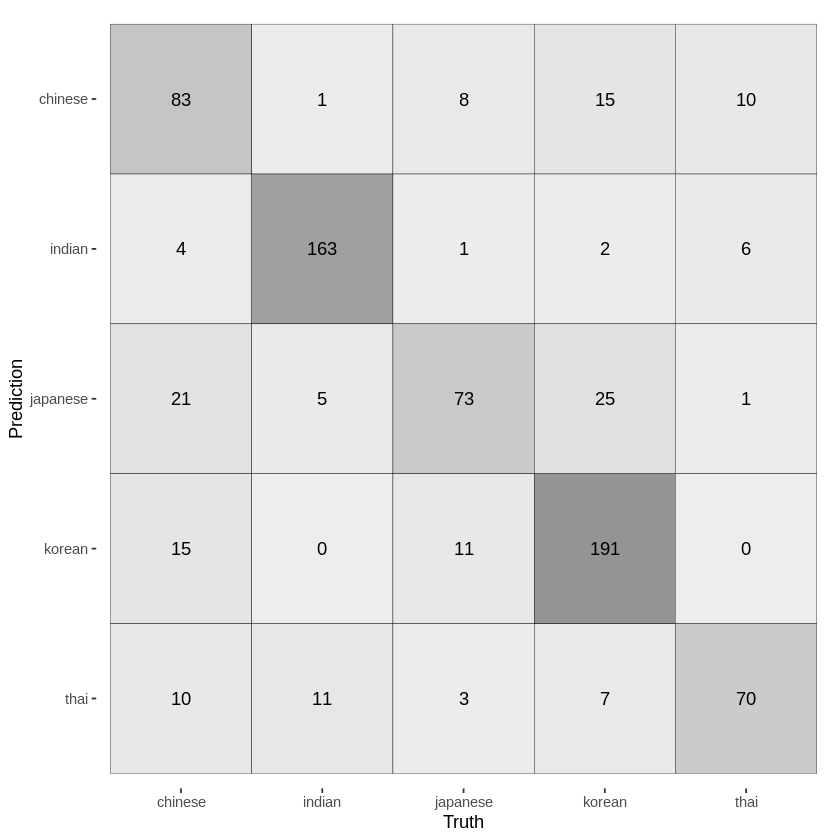

In [11]:
update_geom_defaults(geom = "tile", new = list(color = "black", alpha = 0.7))
# Visualize confusion matrix
results %>% 
  conf_mat(cuisine, .pred_class) %>% 
  autoplot(type = "heatmap")

Die dunkleren Felder in der Konfusionsmatrix zeigen eine hohe Anzahl von Fällen an, und idealerweise sehen Sie eine diagonale Linie aus dunkleren Feldern, die Fälle markieren, bei denen die vorhergesagte und die tatsächliche Kategorie übereinstimmen.

Lassen Sie uns nun zusammenfassende Statistiken für die Konfusionsmatrix berechnen.


In [12]:
# Summary stats for confusion matrix
conf_mat(data = results, truth = cuisine, estimate = .pred_class) %>% 
summary()

.metric              .estimator .estimate
1  accuracy             multiclass 0.7880435
2  kap                  multiclass 0.7276583
3  sens                 macro      0.7780927
4  spec                 macro      0.9477598
5  ppv                  macro      0.7585583
6  npv                  macro      0.9460080
7  mcc                  multiclass 0.7292724
8  j_index              macro      0.7258524
9  bal_accuracy         macro      0.8629262
10 detection_prevalence macro      0.2000000
11 precision            macro      0.7585583
12 recall               macro      0.7780927
13 f_meas               macro      0.7641862

Wenn wir uns auf einige Metriken wie Genauigkeit, Sensitivität und PPV konzentrieren, ist das für den Anfang gar nicht so schlecht 🥳!

## 4. Tiefer eintauchen

Stellen wir uns eine subtile Frage: Nach welchen Kriterien wird eine bestimmte Art von Küche als vorhergesagtes Ergebnis ausgewählt?

Nun, statistische Machine-Learning-Algorithmen, wie die logistische Regression, basieren auf `Wahrscheinlichkeit`. Das bedeutet, dass ein Klassifikator tatsächlich eine Wahrscheinlichkeitsverteilung über eine Menge möglicher Ergebnisse vorhersagt. Die Klasse mit der höchsten Wahrscheinlichkeit wird dann als das wahrscheinlichste Ergebnis für die gegebenen Beobachtungen ausgewählt.

Schauen wir uns das in der Praxis an, indem wir sowohl harte Klassenentscheidungen als auch Wahrscheinlichkeiten betrachten.


In [13]:
# Make hard class prediction and probabilities
results_prob <- cuisines_test %>%
  select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test)) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test, type = "prob"))

# Print out results
results_prob %>% 
  slice_head(n = 5)

cuisine .pred_class .pred_chinese .pred_indian .pred_japanese .pred_korean
1 indian  thai        1.551259e-03  0.4587877    5.988039e-04   2.428503e-04
2 indian  indian      2.637133e-05  0.9999488    6.648651e-07   2.259993e-05
3 indian  indian      1.049433e-03  0.9909982    1.060937e-03   1.644947e-05
4 indian  indian      6.237482e-02  0.4763035    9.136702e-02   3.660913e-01
5 indian  indian      1.431745e-02  0.9418551    2.945239e-02   8.721782e-03
  .pred_thai  
1 5.388194e-01
2 1.577948e-06
3 6.874989e-03
4 3.863391e-03
5 5.653283e-03

✅ Können Sie erklären, warum das Modell ziemlich sicher ist, dass die erste Beobachtung thailändisch ist?

## **🚀Herausforderung**

In dieser Lektion haben Sie Ihre bereinigten Daten verwendet, um ein Machine-Learning-Modell zu erstellen, das anhand einer Reihe von Zutaten eine nationale Küche vorhersagen kann. Nehmen Sie sich etwas Zeit, um die [vielen Optionen](https://www.tidymodels.org/find/parsnip/#models) zu erkunden, die Tidymodels zur Klassifizierung von Daten bietet, sowie [andere Möglichkeiten](https://parsnip.tidymodels.org/articles/articles/Examples.html#multinom_reg-models), um eine multinomiale Regression anzupassen.

#### EIN GROSSES DANKESCHÖN AN:

[`Allison Horst`](https://twitter.com/allison_horst/) für die Erstellung der großartigen Illustrationen, die R einladender und ansprechender machen. Weitere Illustrationen finden Sie in ihrer [Galerie](https://www.google.com/url?q=https://github.com/allisonhorst/stats-illustrations&sa=D&source=editors&ust=1626380772530000&usg=AOvVaw3zcfyCizFQZpkSLzxiiQEM).

[Cassie Breviu](https://www.twitter.com/cassieview) und [Jen Looper](https://www.twitter.com/jenlooper) für die Erstellung der ursprünglichen Python-Version dieses Moduls ♥️

<br>
Hätte gerne ein paar Witze eingebaut, aber ich verstehe keine Food-Wortspiele 😅.

<br>

Viel Spaß beim Lernen,

[Eric](https://twitter.com/ericntay), Gold Microsoft Learn Student Ambassador.



---

**Haftungsausschluss**:  
Dieses Dokument wurde mithilfe des KI-Übersetzungsdienstes [Co-op Translator](https://github.com/Azure/co-op-translator) übersetzt. Obwohl wir uns um Genauigkeit bemühen, weisen wir darauf hin, dass automatisierte Übersetzungen Fehler oder Ungenauigkeiten enthalten können. Das Originaldokument in seiner ursprünglichen Sprache sollte als maßgebliche Quelle betrachtet werden. Für kritische Informationen wird eine professionelle menschliche Übersetzung empfohlen. Wir übernehmen keine Haftung für Missverständnisse oder Fehlinterpretationen, die aus der Nutzung dieser Übersetzung entstehen.
